Imports

In [7]:
__author__ = "Artur Fejklowicz"

# Sources:
# - https://medium.com/@ashins1997/text-classification-dfe370bf7044
# - https://www.kaggle.com/code/shahkan/text-classification-using-logistic-regression
# - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn
# - https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from google.cloud import bigquery
import matplotlib.pyplot as plt
import nltk.stem.snowball
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords

Function to load polish stopwords from file

In [8]:

def load_lines_from_file(filename):
    """Loads newline-delimited strings from a file into a list."""
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            lines = [line.strip() for line in lines]  # Remove trailing newlines
            return lines
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None


Retrive data from BigQuery

df.head()
                               description      Konto
0                         Top-Up by *4356     Top-Up
1                                 Transak    PK Rest
2                                  Amazon    PK Rest
3                      Ihre Lieferadresse    PK Rest
4           Cash at Os.pulku Lotniczego 1    PK Rest
5              Refund from Amz*ksw Kingdo    PK Rest
6                                  Google    PK Rest
7                             Card Top-Up    PK Rest
8              Google Pay Top-Up by *4356    PK Rest
9                                  PayPal    PK Rest
10                             AliExpress    PK Rest
11                       Exchanged to PLN    PK Rest
12                                Allegro    PK Rest
13  Educational Team - Kindergarten No. 1    PK Rest
14                      Cie Du Mont Blanc   PK Artur
15                           Maison Alpes   PK Artur
16                         Place du Poilu   PK Artur
17                     Casino Super

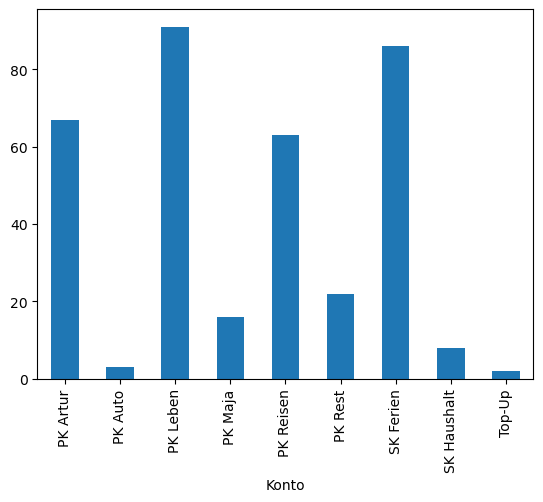

In [9]:
client = bigquery.Client(project="af-finanzen")
query = ("""SELECT
  description
  , Konto
FROM banks.revolut_mapping_internal
""")
df = client.query(query).to_dataframe()  # API request
print(f"df.head()\n {df.head(25)}")
print(df.groupby("Konto").Konto.count())
df.groupby("Konto").Konto.count().plot.bar(ylim=0)
plt.show()


Rest to be nicely splited

stops:
['mis', 'mon', 'hadn', 'einiges', 'wollte', 'vuestro', 'fueras', 'hatten', 'tuyos', 'estuvisteis', "shan't", 'teníamos', 'meiner', 'habido', 'na', 'euch', 'viel', 'fuesen', 'your', "you'd", 'estás', 'tienen', 'stavamo', 'sarebbe', 'nas', 'donde', 'dann', 'hubimos', 'seinen', 'ci', 'derselbe', 'eravate', 'sus', 'jener', 'their', 'von', 'las', 'serais', 'ayons', 'estos', 'fuese', 'tutaj', 'estuvieran', 'par', 'estaré', 'when', 'ihre', 'tú', 'seréis', 'fece', 'estaban', 'fûtes', 'fuiste', 'sareste', 'soit', 'non', 'avons', 'stavate', 'wami', "you'll", 'bardzo', 'sarete', 'tes', 'agl', 'but', 'hatte', 'here', 'otras', 'se', 'estaba', 'auraient', 'eurer', 'hasn', 'solche', 'stessero', 'desde', 'nosotras', "aren't", 'tuviésemos', 'ella', 'estuvo', 'aveva', 'hayan', 'się', 'sie', 'tuviste', 'étant', "don't", 'estuvimos', 'hanno', 'seré', 'stettero', 'oder', 'tutti', 'fummo', 'facciate', 'facessi', 'estéis', 'dov', 'diese', 'vostri', 'è', 'nei', 'algo', 'the', 'dass', 'ces', 'dobrze', '

c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


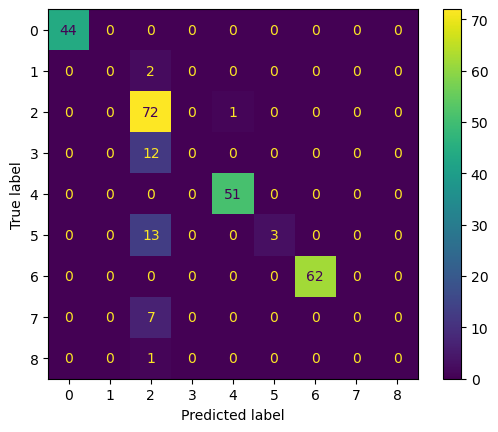

Confusion Matrix: on testing data
[[ 1  0 22  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 1  0 17  0  0  0  0  0  0]
 [ 3  0  1  0  0  0  0  0  0]
 [ 0  0  7  0  5  0  0  0  0]
 [ 2  0  4  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  7  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]]


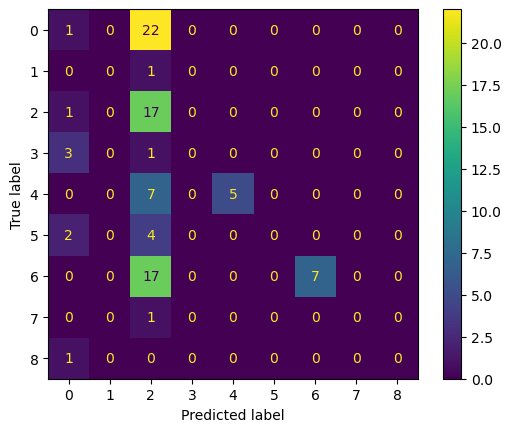

In [10]:

stops_eng = set(stopwords.words('english'))
stops_ger = set(stopwords.words('german'))
stops_ita = set(stopwords.words('italian'))
stops_spa = set(stopwords.words('spanish'))
stops_fra = set(stopwords.words('french'))
stops_pol = set(load_lines_from_file("../../python/logistic_regression_classification/polish.txt"))
stops = stops_eng.union(stops_ger).union(stops_ita).union(stops_spa).union(stops_fra)
if stops_pol:
    stops = stops.union(stops_pol)
stops = list(stops)
print(f"stops:\n{stops}")
print(f"stops type:\n{type(stops)}")

vectorizer = TfidfVectorizer(
    min_df=0.0001,
    stop_words=stops,
    max_features=5000,
    sublinear_tf=True, norm='l2', ngram_range=(1, 1))
final_features = vectorizer.fit_transform(df['description']).toarray()
print(f"final_features.shape:\n{final_features.shape}")
#np.set_printoptions(threshold=np.inf)
#print(f"final_featurese:\n{final_features}")

X = df['description']
Y = df['Konto']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k="all")),
                     ('clf',  LogisticRegression(multi_class='ovr', solver='liblinear', random_state=0))])

model = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
classification_report = classification_report(ytest, model.predict(X_test))
confusion_matrix_training = confusion_matrix(np.array(y_train), model.predict(X_train))
confusion_matrix_testing = confusion_matrix(ytest, model.predict(X_test))

print(classification_report)

print("Confusion Matrix: on training data")
print(confusion_matrix_training)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training)
disp.plot()
plt.show()

print("Confusion Matrix: on testing data")
print(confusion_matrix_testing)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing)
disp.plot()
plt.show()